In [1]:
%matplotlib inline   
%config InlineBackend.figure_format = 'svg'
LARGE_FIG_SIZE=(20, 15)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [3]:
def nan_info(df, hide_no_nans=True):
    nans_count = df.isnull().sum()
    nans_percent = 100*nans_count/df.shape[0]
    nan_df = pd.DataFrame({'count': nans_count, 'percent': nans_percent}).sort_values('percent', axis=0, ascending=False)
    if hide_no_nans:
        return nan_df[nan_df['count']!=0]
    return nan_df

### Get the data

- Load the training and testing data
- Validate there are no NaNs

In [4]:
training_data = pd.read_csv('datasets/train.csv')
test_data = pd.read_csv('datasets/test.csv')

In [5]:
nan_info(training_data), nan_info(test_data)

(Empty DataFrame
 Columns: [count, percent]
 Index: [],
 Empty DataFrame
 Columns: [count, percent]
 Index: [])

- Split the train and test data into features and labels

There are 42k input images of hand written digits and 28k test images

each image is given as a array of 784 values

In [6]:
train_y = training_data.to_numpy()[:, 0].reshape((training_data.shape[0], 1))
train_x = training_data.to_numpy()[:, 1:]

test_x = test_data.to_numpy()

print(train_x.shape, train_y.shape, test_x.shape)

(42000, 784) (42000, 1) (28000, 784)


In [7]:
labels = training_data['label']
labels.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

Number of examples of classes 1 vs 5 difference is significant. What to do?

### Visualize the data
    - reshape the data into a square image 28 x 28

In [8]:
np.sqrt(784)

28.0

In [9]:
def get_image_of_a_number(num):
    indices_of_num = np.where(train_y==num)[0]
    rand_index = indices_of_num[np.random.randint(0,indices_of_num.shape[0])]
    return train_x[rand_index,:].reshape((28, 28))

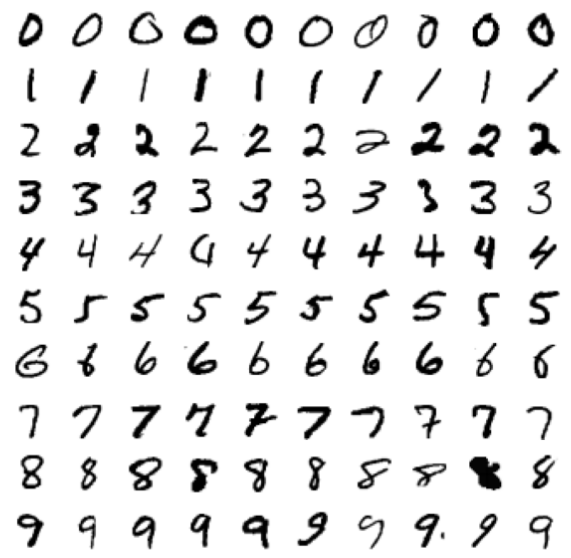

In [10]:
fig, axes = plt.subplots(10, 10, sharex="col", sharey="row", figsize=(10,10))
for num in range(10):
    for i in range(10):
        ax = axes[num][i]
        ax.imshow(get_image_of_a_number(num), cmap='binary')
        ax.axis('off')

What is the range of pixel values? should be 0 to 255

In [11]:
train_x.min(), train_x.max()

(0, 255)

### Normalize the Data

Gradient descent like normalized, unskewed numbers

In [12]:
def preprocess_data(train_x, test_x):
    train_x_norm = train_x/255
    test_x_norm = test_x/255
    
    return train_x_norm, test_x_norm

In [13]:
train_x_norm, test_x_norm = preprocess_data(train_x, test_x)

In [14]:
train_y_oh = keras.utils.to_categorical(train_y)

In [15]:
train_y_oh.shape

(42000, 10)

### Prepare the Model

In [59]:
def plot_learning_curves(history):
    # summarize history for accuracy
    fig, [ax1, ax2] = plt.subplots(2, 1, sharex="col", sharey="row", figsize=(8,8))
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'dev'], loc='upper left')

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'dev'], loc='upper left')

In [60]:
m, n = train_x_norm.shape

In [65]:
def make_model_3L_128(n, dropout_rate):
    
    inputs = keras.Input(shape=(n,))
    x = keras.layers.Dense(128, activation='relu', kernel_initializer='glorot_normal')(inputs)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(128, activation='relu', kernel_initializer='glorot_normal')(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    outputs = keras.layers.Dense(10, activation='softmax', kernel_initializer='glorot_normal')(x)

    model = keras.Model(inputs, outputs, name='digit_recognizer-3-128_128_10')
    return model

In [122]:
dropout_rate=0.2
name = 'digit_recognizer-layers=3-128_128_10'
name = name + '-dropout_rate=' + str(dropout_rate)
model = make_model_3L_128(n, dropout_rate)

# learning_rate=0.0003
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=175,
    decay_rate=0.96,
    staircase=True
)



name = name + '-adam_learning_rate=ExponentialDecay' + str(initial_learning_rate)
adam = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [123]:
history=model.fit(train_x_norm, 
          train_y_oh, 
          epochs=175, 
          batch_size=1024,
          validation_split=0.1,
          verbose=2, 
          use_multiprocessing=True
         )

Epoch 1/175
37/37 - 0s - loss: 1.1491 - accuracy: 0.6591 - val_loss: 0.3997 - val_accuracy: 0.8879
Epoch 2/175
37/37 - 0s - loss: 0.4132 - accuracy: 0.8754 - val_loss: 0.2743 - val_accuracy: 0.9224
Epoch 3/175
37/37 - 0s - loss: 0.3067 - accuracy: 0.9084 - val_loss: 0.2204 - val_accuracy: 0.9360
Epoch 4/175
37/37 - 0s - loss: 0.2501 - accuracy: 0.9273 - val_loss: 0.1885 - val_accuracy: 0.9464
Epoch 5/175
37/37 - 0s - loss: 0.2156 - accuracy: 0.9365 - val_loss: 0.1612 - val_accuracy: 0.9526
Epoch 6/175
37/37 - 0s - loss: 0.1900 - accuracy: 0.9444 - val_loss: 0.1497 - val_accuracy: 0.9557
Epoch 7/175
37/37 - 0s - loss: 0.1670 - accuracy: 0.9503 - val_loss: 0.1393 - val_accuracy: 0.9579
Epoch 8/175
37/37 - 0s - loss: 0.1536 - accuracy: 0.9542 - val_loss: 0.1296 - val_accuracy: 0.9586
Epoch 9/175
37/37 - 0s - loss: 0.1399 - accuracy: 0.9582 - val_loss: 0.1218 - val_accuracy: 0.9593
Epoch 10/175
37/37 - 0s - loss: 0.1307 - accuracy: 0.9609 - val_loss: 0.1176 - val_accuracy: 0.9633
Epoch 11/

37/37 - 0s - loss: 0.0139 - accuracy: 0.9956 - val_loss: 0.0917 - val_accuracy: 0.9781
Epoch 84/175
37/37 - 0s - loss: 0.0132 - accuracy: 0.9957 - val_loss: 0.0942 - val_accuracy: 0.9776
Epoch 85/175
37/37 - 0s - loss: 0.0130 - accuracy: 0.9961 - val_loss: 0.0945 - val_accuracy: 0.9776
Epoch 86/175
37/37 - 0s - loss: 0.0139 - accuracy: 0.9953 - val_loss: 0.0942 - val_accuracy: 0.9781
Epoch 87/175
37/37 - 0s - loss: 0.0131 - accuracy: 0.9960 - val_loss: 0.0945 - val_accuracy: 0.9781
Epoch 88/175
37/37 - 0s - loss: 0.0114 - accuracy: 0.9964 - val_loss: 0.0972 - val_accuracy: 0.9788
Epoch 89/175
37/37 - 0s - loss: 0.0128 - accuracy: 0.9962 - val_loss: 0.0979 - val_accuracy: 0.9788
Epoch 90/175
37/37 - 0s - loss: 0.0129 - accuracy: 0.9958 - val_loss: 0.0963 - val_accuracy: 0.9776
Epoch 91/175
37/37 - 0s - loss: 0.0118 - accuracy: 0.9965 - val_loss: 0.0977 - val_accuracy: 0.9776
Epoch 92/175
37/37 - 0s - loss: 0.0131 - accuracy: 0.9958 - val_loss: 0.0961 - val_accuracy: 0.9776
Epoch 93/175


Epoch 165/175
37/37 - 0s - loss: 0.0064 - accuracy: 0.9980 - val_loss: 0.1076 - val_accuracy: 0.9779
Epoch 166/175
37/37 - 0s - loss: 0.0062 - accuracy: 0.9981 - val_loss: 0.1084 - val_accuracy: 0.9783
Epoch 167/175
37/37 - 0s - loss: 0.0069 - accuracy: 0.9979 - val_loss: 0.1070 - val_accuracy: 0.9790
Epoch 168/175
37/37 - 0s - loss: 0.0070 - accuracy: 0.9979 - val_loss: 0.1073 - val_accuracy: 0.9779
Epoch 169/175
37/37 - 0s - loss: 0.0070 - accuracy: 0.9979 - val_loss: 0.1040 - val_accuracy: 0.9786
Epoch 170/175
37/37 - 0s - loss: 0.0063 - accuracy: 0.9982 - val_loss: 0.1039 - val_accuracy: 0.9786
Epoch 171/175
37/37 - 0s - loss: 0.0067 - accuracy: 0.9979 - val_loss: 0.1059 - val_accuracy: 0.9781
Epoch 172/175
37/37 - 0s - loss: 0.0062 - accuracy: 0.9982 - val_loss: 0.1062 - val_accuracy: 0.9781
Epoch 173/175
37/37 - 0s - loss: 0.0062 - accuracy: 0.9981 - val_loss: 0.1097 - val_accuracy: 0.9786
Epoch 174/175
37/37 - 0s - loss: 0.0064 - accuracy: 0.9979 - val_loss: 0.1083 - val_accurac

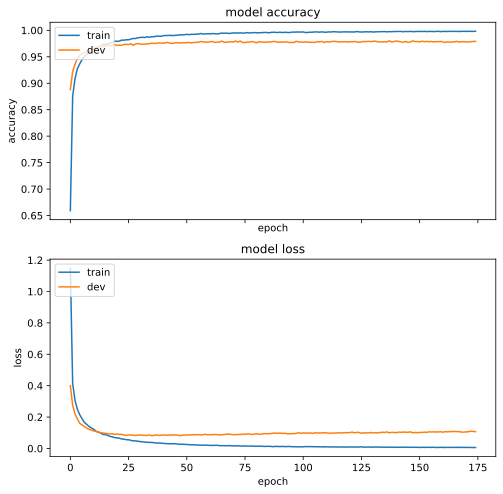

In [124]:
plot_learning_curves(history)

In [236]:
name = name + '-accuracy=' + str(np.round(history.history['accuracy'][-1],5))
name = name + '-val_accuracy=' + str(np.round(history.history['val_accuracy'][-1], 5))

In [237]:
model.save('models/'+name)

INFO:tensorflow:Assets written to: models/digit_recognizer-layers=3-128_128_10-dropout_rate=0.2-adam_learning_rate=ExponentialDecay0.001-accuracy=0.99825-val_accuracy=0.97905/assets


In [28]:
def predict(model, test_x, fname):
    preds = model.predict(test_x)
    preds_class = np.argmax(preds, axis=1)
    df = pd.DataFrame({'ImageId': np.arange(1,test_x.shape[0]+1), 'Label': preds_class})
    df.to_csv(fname, index=False, header=True)

In [239]:
predict(model, test_x_norm, name)

### Visualize Test Set

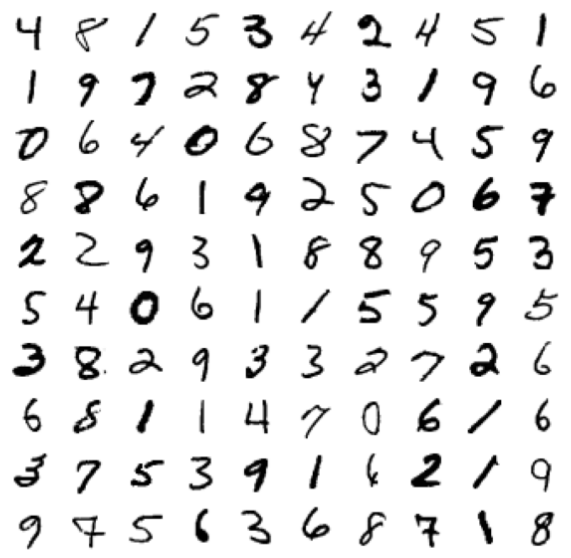

In [469]:
fig, axes = plt.subplots(10, 10, sharex="col", sharey="row", figsize=(10,10))
for num in range(10):
    for i in range(10):
        ax = axes[num][i]
        ax.imshow(test_x[np.random.randint(0, test_x.shape[0])].reshape((28,28)), cmap='binary')
        ax.axis('off')

### Visualizing Learning rate scheduler with exponential decay

In [106]:
def decayed_learning_rate(step, initial_learning_rate, decay_steps, decay_rate, staircase):
    if staircase:
        return initial_learning_rate * np.power(decay_rate, (step // decay_steps))
    else:
        return initial_learning_rate * np.power(decay_rate,  (step / decay_steps))
    
steps = np.arange(1,37*175)

final learning rate:  0.0002300193593005427


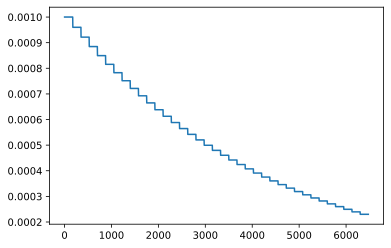

In [119]:
initial_learning_rate = 0.001
decay_steps=175
decay_rate=0.96
staircase=True
learning_rates = decayed_learning_rate(steps, initial_learning_rate, decay_steps, decay_rate, staircase)

plt.plot(steps, learning_rates)
print('final learning rate: ', learning_rates[-1])

### Data Augmentation

In [233]:
gen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15, 
    width_shift_range=0.08, 
    shear_range=0.3, 
    height_shift_range=0.08, 
    zoom_range=0.1
)
batches = gen.flow(train_x[:8].reshape(8, 28, 28, 1), train_y[:8], batch_size=8)
# val_batches = gen.flow(X_val, y_val, batch_size=64)

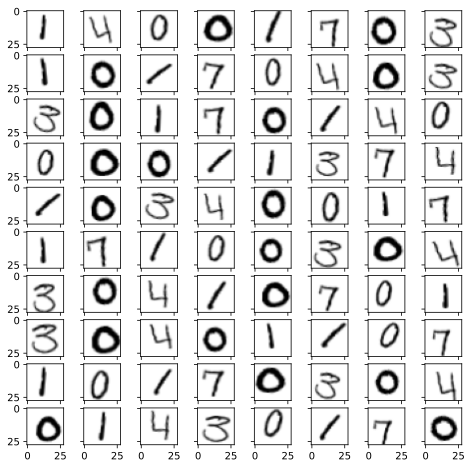

In [235]:
fig, axes = plt.subplots(10, 8, sharex="col", sharey="row", figsize=(8,8))
for batch_num in range(10):
    batch = batches.next()
    x = batch[0]
    ni,_,_,_ = x.shape
    for i in range(ni):
        ax = axes[batch_num][i]
        ax.imshow(x[i], cmap='binary')
    
    

### New Model with Data Augmentation input = (m, 28, 28, 1) rank 4 ternsor

In [48]:
def normalize_and_reshape_data(train_x, test_x):
    mean = np.mean(train_x)
    std = np.std(train_x)
    
    train_x = (train_x - mean) / std
    test_x = (test_x - mean) / std
    
    return train_x.reshape(train_x.shape[0], 28, 28, 1), test_x.reshape(test_x.shape[0], 28, 28, 1)

In [49]:
X_train, X_test = normalize_and_reshape_data(train_x, test_x)

In [50]:
from sklearn.model_selection import train_test_split
X = X_train
y = train_y_oh
X_train, X_val, y_train, y_val = train_test_split(X_train, train_y_oh, test_size=0.10, random_state=42)

In [51]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((37800, 28, 28, 1), (4200, 28, 28, 1), (37800, 10), (4200, 10))

In [96]:
gen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15, 
    width_shift_range=0.08, 
    shear_range=0.3, 
    height_shift_range=0.08, 
    zoom_range=0.1
)
batches = gen.flow(X_train, y_train, batch_size=64)
# val_batches = gen.flow(X_val, y_val, batch_size=64)

In [21]:
def make_model_3L_128_with_data_augmentation(dropout_rate):
    inputs = keras.Input(shape=(28,28,1))
    x = keras.layers.Flatten()(inputs)
    x = keras.layers.Dense(128, activation='relu', kernel_initializer='glorot_normal')(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(128, activation='relu', kernel_initializer='glorot_normal')(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    outputs = keras.layers.Dense(10, activation='softmax', kernel_initializer='glorot_normal')(x)

    model = keras.Model(inputs, outputs, name='digit_recognizer-3-128_128_10_with_data_augmentation')
    return model

In [22]:
dropout_rate=0.1
name = 'digit_recognizer-layers=3-128_128_10'
name = name + '-dropout_rate=' + str(dropout_rate)
model = make_model_3L_128_with_data_augmentation(dropout_rate)

# learning_rate=0.0003
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=batches.n//64,
    decay_rate=0.96,
    staircase=True
)

# name = name + '-adam_learning_rate=ExponentialDecay' + str(initial_learning_rate)
adam = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
history=model.fit(x=batches, 
                  epochs=60, 
                  steps_per_epoch=batches.n//64, 
                  validation_data=(X_val, y_val),
                  verbose=2
         )

Epoch 1/60
590/590 - 9s - loss: 0.6423 - accuracy: 0.7889 - val_loss: 0.1716 - val_accuracy: 0.9481
Epoch 2/60
590/590 - 8s - loss: 0.3175 - accuracy: 0.9022 - val_loss: 0.1417 - val_accuracy: 0.9571
Epoch 3/60
590/590 - 8s - loss: 0.2565 - accuracy: 0.9208 - val_loss: 0.1135 - val_accuracy: 0.9648
Epoch 4/60
590/590 - 8s - loss: 0.2271 - accuracy: 0.9292 - val_loss: 0.1045 - val_accuracy: 0.9688
Epoch 5/60
590/590 - 8s - loss: 0.2033 - accuracy: 0.9373 - val_loss: 0.0964 - val_accuracy: 0.9710
Epoch 6/60
590/590 - 8s - loss: 0.1911 - accuracy: 0.9403 - val_loss: 0.0879 - val_accuracy: 0.9719
Epoch 7/60
590/590 - 8s - loss: 0.1832 - accuracy: 0.9427 - val_loss: 0.0809 - val_accuracy: 0.9764
Epoch 8/60
590/590 - 8s - loss: 0.1684 - accuracy: 0.9470 - val_loss: 0.0795 - val_accuracy: 0.9740
Epoch 9/60
590/590 - 8s - loss: 0.1619 - accuracy: 0.9494 - val_loss: 0.0800 - val_accuracy: 0.9750
Epoch 10/60
590/590 - 8s - loss: 0.1571 - accuracy: 0.9528 - val_loss: 0.0764 - val_accuracy: 0.9767

In [24]:
name = 'mlp-layers=3-128-128-10-data_aug-rot=15-zoom=0.1-dropout_rate=0.1-learning_rate_exp_decay=0.001'
name = name + '-accuracy=' + str(np.round(history.history['accuracy'][-1],5))
name = name + '-val_accuracy=' + str(np.round(history.history['val_accuracy'][-1], 5))

In [27]:
model.save('models/'+name)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/mlp-layers=3-128-128-10-data_aug-rot=15-zoom=0.1-dropout_rate=0.1-learning_rate_exp_decay=0.001-accuracy=0.97517-val_accuracy=0.98643/assets


In [29]:
predict(model, X_test, name+'.csv')

In [35]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense, Activation, MaxPooling2D, Flatten

In [97]:
def make_cnn_model():
    inputs = Input(shape=(28,28,1))
    x = Conv2D(32, (3,3), kernel_initializer='glorot_normal')(inputs)
    x = BatchNormalization(axis=1)(x)
    x = Activation('relu')(x)
    
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='glorot_normal')(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
                           
    x = Conv2D(64, (3,3), kernel_initializer='glorot_normal')(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3,3), activation='relu', kernel_initializer='glorot_normal')(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Flatten()(x)
    
    x = Dense(128, activation='relu', kernel_initializer='glorot_normal')(x)
    x = Dense(64, activation='relu', kernel_initializer='glorot_normal')(x)
    outputs = keras.layers.Dense(10, activation='softmax', kernel_initializer='glorot_normal')(x)
    model = keras.Model(inputs, outputs, name='cnn')
    return model

In [98]:
model = make_cnn_model()
model.summary()

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_24 (Batc (None, 26, 26, 32)        104       
_________________________________________________________________
activation_24 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_25 (Batc (None, 24, 24, 32)        96        
_________________________________________________________________
activation_25 (Activation)   (None, 24, 24, 32)        0       

In [99]:
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=batches.n//64,
    decay_rate=0.96,
    staircase=True
)

# name = name + '-adam_learning_rate=ExponentialDecay' + str(initial_learning_rate)
adam = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
history=model.fit(x=batches, 
                  epochs=60, 
                  steps_per_epoch=batches.n//64, 
                  validation_data=(X_val, y_val),
                  verbose=2
         )

Epoch 1/60
590/590 - 72s - loss: 0.2426 - accuracy: 0.9234 - val_loss: 0.0480 - val_accuracy: 0.9848
Epoch 2/60
590/590 - 71s - loss: 0.0806 - accuracy: 0.9754 - val_loss: 0.0583 - val_accuracy: 0.9833
Epoch 3/60
590/590 - 72s - loss: 0.0631 - accuracy: 0.9810 - val_loss: 0.0308 - val_accuracy: 0.9917
Epoch 4/60
590/590 - 72s - loss: 0.0518 - accuracy: 0.9835 - val_loss: 0.0280 - val_accuracy: 0.9919
Epoch 5/60
590/590 - 72s - loss: 0.0469 - accuracy: 0.9853 - val_loss: 0.0245 - val_accuracy: 0.9921
Epoch 6/60
590/590 - 71s - loss: 0.0406 - accuracy: 0.9876 - val_loss: 0.0286 - val_accuracy: 0.9921
Epoch 7/60
590/590 - 72s - loss: 0.0369 - accuracy: 0.9882 - val_loss: 0.0279 - val_accuracy: 0.9924
Epoch 8/60
590/590 - 74s - loss: 0.0331 - accuracy: 0.9900 - val_loss: 0.0330 - val_accuracy: 0.9919
Epoch 9/60
590/590 - 72s - loss: 0.0306 - accuracy: 0.9905 - val_loss: 0.0278 - val_accuracy: 0.9919
Epoch 10/60


KeyboardInterrupt: 

In [62]:
name = 'cnn-32-32-pool-64-64-pool-128-64-10-data_aug-rot=15-zoom=0.1-learning_rate_exp_decay=0.001'
# name = name + '-accuracy=' + str(np.round(history.history['accuracy'][-1],5))
# name = name + '-val_accuracy=' + str(np.round(history.history['val_accuracy'][-1], 5))

In [63]:
model.save('models/'+name)

INFO:tensorflow:Assets written to: models/cnn-32-32-pool-64-64-pool-128-64-10-data_aug-rot=15-zoom=0.1-learning_rate_exp_decay=0.001/assets


In [64]:
predict(model, X_test, name+'.csv')

### Class Wieghts for Unbalanced Datasets

In [65]:
from sklearn.utils import class_weight

In [102]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(labels.values),
                                                 y = labels.values)
class_weights_dict = dict(enumerate(class_weights))

In [104]:
history=model.fit(x=batches, 
                  epochs=5, 
                  steps_per_epoch=batches.n//64, 
                  validation_data=(X_val, y_val),
                  class_weight = class_weights_dict,
                  verbose=2
         )

Epoch 1/5
590/590 - 81s - loss: 0.0336 - accuracy: 0.9901 - val_loss: 0.0337 - val_accuracy: 0.9902
Epoch 2/5
590/590 - 67s - loss: 0.0293 - accuracy: 0.9909 - val_loss: 0.0249 - val_accuracy: 0.9924
Epoch 3/5
590/590 - 66s - loss: 0.0266 - accuracy: 0.9912 - val_loss: 0.0303 - val_accuracy: 0.9917
Epoch 4/5
590/590 - 71s - loss: 0.0243 - accuracy: 0.9923 - val_loss: 0.0239 - val_accuracy: 0.9926
Epoch 5/5
590/590 - 73s - loss: 0.0227 - accuracy: 0.9925 - val_loss: 0.0220 - val_accuracy: 0.9924


In [105]:
name = 'cnn-32-32-pool-64-64-pool-128-64-10-data_aug-rot=15-zoom=0.1-learning_rate_exp_decay=0.001-class_weighted'
name = name + '-accuracy=' + str(np.round(history.history['accuracy'][-1],5))
name = name + '-val_accuracy=' + str(np.round(history.history['val_accuracy'][-1], 5))

In [107]:
model.save('models/'+name)

INFO:tensorflow:Assets written to: models/cnn-32-32-pool-64-64-pool-128-64-10-data_aug-rot=15-zoom=0.1-learning_rate_exp_decay=0.001-class_weighted-accuracy=0.99247-val_accuracy=0.99238/assets


In [108]:
predict(model, X_test, name+'.csv')

### Error Analysis

In [110]:
preds = model.predict(X_val)
preds_class = np.argmax(preds, axis=1)

In [120]:
labels_val = np.argmax(y_val,axis=1)

In [124]:
mask = preds_class != labels_val
misclassified_images = X_val[mask]

mean = np.mean(train_x)
std = np.std(train_x)

misclassified_images = misclassified_images*std + mean

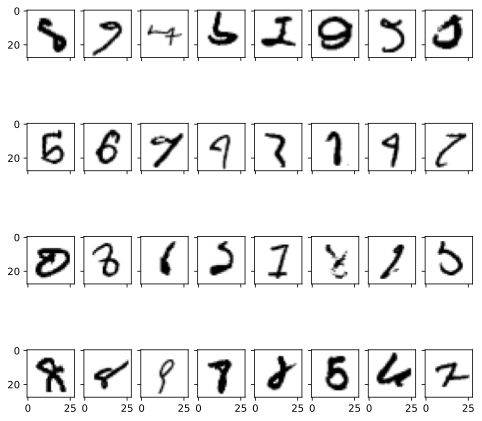

In [126]:
fig, axes = plt.subplots(4, 8, sharex="col", sharey="row", figsize=(8,8))
i=0
for row in range(4):
    for col in range(8):
        ax = axes[row][col]
        ax.imshow(misclassified_images[i], cmap='binary')
        i=i+1

In [130]:
print?

In [133]:
actual_labels = labels_val[mask]
i=0
for row in range(4):
    for col in range(8):
        print(actual_labels[i], '\t', end='')
        i=i+1
    print('\n')

5 	9 	7 	6 	2 	9 	5 	0 	

5 	6 	7 	4 	3 	1 	4 	7 	

0 	8 	1 	2 	7 	8 	1 	5 	

8 	8 	9 	8 	2 	5 	6 	2 	

